In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras

from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Dense
from keras.layers import Input
from keras.optimizers import Adam
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import random

Using TensorFlow backend.


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"cleanpegasus","key":"e9ef704ab5501fb855464d9696c823c7"}'}

In [0]:
!pip install -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
cp kaggle.json ~/.kaggle/

In [9]:
!kaggle competitions download -c challenges-in-representation-learning-facial-expression-recognition-challenge

  0% 0.00/7.01k [00:00<?, ?B/s]
100% 7.01k/7.01k [00:00<00:00, 14.0MB/s]
 84% 77.0M/92.0M [00:01<00:00, 50.9MB/s]
100% 92.0M/92.0M [00:01<00:00, 79.2MB/s]


In [3]:
ls

 data                     fer2013/        'kaggle (1).json'   sample_data/
 example_submission.csv   fer2013.tar.gz   kaggle.json        train_data.csv


In [0]:
!tar -xzf fer2013.tar.gz

In [20]:
ls

data                    fer2013/        kaggle.json   train_data.csv
example_submission.csv  fer2013.tar.gz  sample_data/


In [0]:
df = pd.read_csv('fer2013/fer2013.csv')

In [0]:
image = np.asarray(df['pixels'])
y_train = np.asarray(df['emotion'])

## Data Preprocessing

In [0]:
X_train = []
for i in range(np.shape(image)[0]):
    im = image[i]
    im = im.split(' ')
    im = np.asarray(im)
    X_train.append(im.reshape(48, 48))

In [7]:
X_train = np.asarray(X_train, dtype = float)
print(X_train.shape)
print(y_train.shape)

(35887, 48, 48)
(35887,)


6


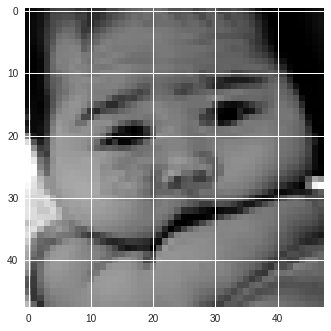

In [8]:
x = random.randint(0, np.shape(image)[0])
q = np.asarray(X_train[x], dtype=float)
print(y_train[x])
plt.imshow(q, cmap = plt.get_cmap("gray"))

In [0]:
num_classes = 7
y_train = to_categorical(y_train, 7)

In [10]:
print(X_train.shape)

(35887, 48, 48)


In [0]:
X_train = X_train/255

In [0]:
X_train = X_train.reshape(35887, 48, 48, 1)

In [0]:
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

In [0]:
def neural_model(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model


In [15]:
input_shape = (48, 48, 1)
model = neural_model(input_shape, num_classes)
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 48, 48, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 8)    72          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 46, 46, 8)    32          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 46, 46, 8)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(28709, 48, 48, 1)
(28709, 7)
(7178, 48, 48, 1)
(7178, 7)


In [18]:
model.fit_generator(data_generator.flow(X_train, y_train, 32),
                   steps_per_epoch = len(X_train)/32,
                   epochs = 500,
                   verbose = 1,
                   validation_data = (X_val, y_val))

Epoch 1/500
898/897 [==============================] - 49s 55ms/step - loss: 1.8009 - acc: 0.3125 - val_loss: 1.6176 - val_acc: 0.3963
Epoch 2/500
898/897 [==============================] - 47s 52ms/step - loss: 1.5378 - acc: 0.4225 - val_loss: 1.5578 - val_acc: 0.4246
Epoch 3/500
898/897 [==============================] - 46s 52ms/step - loss: 1.4122 - acc: 0.4713 - val_loss: 1.3889 - val_acc: 0.4812
Epoch 4/500
898/897 [==============================] - 48s 53ms/step - loss: 1.3422 - acc: 0.4964 - val_loss: 1.3088 - val_acc: 0.5045
Epoch 5/500
898/897 [==============================] - 48s 53ms/step - loss: 1.2952 - acc: 0.5152 - val_loss: 1.3784 - val_acc: 0.4868
Epoch 6/500
898/897 [==============================] - 46s 52ms/step - loss: 1.2594 - acc: 0.5292 - val_loss: 1.3137 - val_acc: 0.5091
Epoch 7/500
898/897 [==============================] - 47s 52ms/step - loss: 1.2332 - acc: 0.5355 - val_loss: 1.2517 - val_acc: 0.5332
Epoch 8/500
898/897 [==============================] - 

KeyboardInterrupt: ignored

In [0]:
model.save('recog.h5')
from google.colab import files
files.download('recog.h5')